In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl

### Calculate the max mode index
For TE mode,
$$\phi_c = arctan \frac{\sqrt{n_s^2 - n_c^2}}{\sqrt{n_f^2 - n_s^2}}$$
$$m_c = int[\frac{2d}{\lambda}\sqrt{n_f^2 - n_s^2} - \frac{\phi_c}{\pi}]$$

For TM mode,
$$\phi_c^{'} = arctan \frac{n_f^2}{n_c^2}\frac{\sqrt{n_s^2 - n_c^2}}{\sqrt{n_f^2 - n_s^2}}$$
$$m_c = int[\frac{2d}{\lambda}\sqrt{n_f^2 - n_s^2} - \frac{\phi_c^{'}}{\pi}]$$

### Calculate effective index
For **TE** mode, 
$$Kd=m\pi + arctan\frac{\sqrt{\beta^2 - n_s^2k_0^2}}{K}+arctan\frac{\sqrt{\beta^2 - n_c^2k_0^2}}{K}$$

For **TM** mode,
$$Kd=m\pi + arctan\frac{n_f^2}{n_s^2}\frac{\sqrt{\beta^2 - n_s^2k_0^2}}{K}+arctan\frac{n_f^2}{n_c^2}\frac{\sqrt{\beta^2 - n_c^2k_0^2}}{K}$$

If we solve $K$ by the numerical method, then the effective index
$$\beta = n_f sin\alpha \cdot k_0 = \sqrt{n_f^2 k_0^2 - K^2}$$
$$n_{eff}= n_f sin\alpha =  \frac{\beta}{k_0}$$

In [7]:
class WaveguideModeAnalyzer:
    def __init__(self, nf=1.5, ns=1.0, nc=1.0, wvl=500e-9, d=3e-6, device='cpu'):
        """
        Initialize the WaveguideModeAnalyzer with the given parameters.

        parameters:
        nf : float - Refractive index of the waveguide.
        ns : float - Refractive index of the substrate.
        nc : float - Refractive index of the cover.
        wvl : float - Wavelength of the light in vacuum.
        d : float - Thickness of the waveguide.
        device : str - Device to run the calculations on ('cpu' or 'cuda').
        """
        self.nf = torch.tensor(nf, dtype=torch.float32, device=device)
        self.ns = torch.tensor(ns, dtype=torch.float32, device=device)
        self.nc = torch.tensor(nc, dtype=torch.float32, device=device)
        self.wvl = torch.tensor(wvl, dtype=torch.float32, device=device)
        self.d = torch.tensor(d, dtype=torch.float32, device=device)
        self.device = device
        self.k0 = 2 * torch.pi / self.wvl     # Free space wave number

        self.mu_0 = torch.tensor(4 * torch.pi * 1e-7, dtype=torch.float32, device=device)  # Permeability of free space
        self.eps_0 = torch.tensor(8.854187817e-12, dtype=torch.float32, device=device)  # Permittivity of free space
        self.c = torch.tensor(3e8, dtype=torch.float32, device=device)  # Speed of light in vacuum
        self.omega = 2 * torch.pi / self.wvl * self.c  # Angular frequency

    def max_mode_index(self, mode_type='TE'):
        if mode_type == 'TE':
            phi_c = torch.atan(torch.sqrt(self.ns**2 - self.nc**2) / torch.sqrt(self.nf**2 - self.ns**2))
        elif mode_type == 'TM':
            phi_c = torch.atan((self.nf**2 / self.nc**2) * torch.sqrt(self.ns**2 - self.nc**2) / torch.sqrt(self.nf**2 - self.ns**2))

        m = int(2 * self.d / self.wvl * torch.sqrt(self.nf**2 - self.ns**2) - phi_c / torch.pi)
        if m < 0:
            m = 0
        return m

    def effective_index(self, mode_index=1, max_iter=100, tol=1e-6, mode_type='TE'):
        """
        Find intersections of mode equations using dichotomy method.
        """

        Kc = self.k0 * torch.sqrt(self.nf**2 - self.ns**2)      # cutoff wave number

        # initial 
        K_min = torch.tensor(1e-6, device=self.device)         # make sure to avoid division by zero
        K_max = Kc - K_min

        def equation(K):
            beta_sq = self.nf**2 * self.k0**2 - K**2
            p = torch.sqrt(beta_sq - self.ns**2 * self.k0**2)
            q = torch.sqrt(beta_sq - self.nc**2 * self.k0**2)

            if mode_type == 'TE':
                f_mode_val = (
                    mode_index * torch.pi + 
                    torch.atan(p / K) +
                    torch.atan(q / K)
                )
            elif mode_type == 'TM':
                f_mode_val = (
                    mode_index * torch.pi + 
                    torch.atan((self.nf**2 / self.ns**2) * (p / K)) +
                    torch.atan((self.nf**2 / self.nc**2) * (q / K))
                )
            
            return K * self.d - f_mode_val
        
        # use dichotomy method
        for _ in range(max_iter):
            K_mid = (K_min + K_max) / 2
            f_mid = equation(K_mid)

            if torch.abs(f_mid) < tol:
                beta = torch.sqrt(self.nf**2 * self.k0**2 - K_mid**2)
                n_eff = beta / self.k0
                return n_eff

            f_min = equation(K_min)
            if f_mid * f_min < 0:
                K_max = K_mid
            else:
                K_min = K_mid
        # if not converged, return the last value
        beta = torch.sqrt(self.nf**2 * self.k0**2 - ((K_min + K_max) / 2)**2)
        n_eff = beta / self.k0
        return n_eff
    
    def field(self, x, z, t, n_eff, mode_index, mode_type='TE'):
        """
        Calculate the field distribution for the given mode.
        """
        X, Z = torch.meshgrid(x, z, indexing='ij')
        # auto-gradient
        X.requires_grad_(True)
        Z.requires_grad_(True)

        beta = n_eff * self.k0
        K_root = torch.sqrt(self.nf**2 * self.k0**2 - beta**2)
        # calculate p and q
        p = torch.sqrt(beta**2 - self.ns**2 * self.k0**2)
        q = torch.sqrt(beta**2 - self.nc**2 * self.k0**2)

        if mode_type == 'TE':
            phi = 1 / 2 * torch.atan(q / K_root) - 1 / 2 * torch.atan(p / K_root) + np.pi * mode_index / 2

            # amplitude
            A = 1
            B = A * torch.cos(K_root * (self.d / 2) - phi)
            C = A * torch.cos(K_root * (self.d / 2) + phi)

            # # calculate Ey field
            Ey = torch.zeros_like(X, dtype=torch.complex64, device=self.device)

            mask_center = torch.abs(X) <= self.d / 2
            Ey[mask_center] = A * torch.cos(K_root * X[mask_center] + phi) *  \
                            torch.exp(-1j * beta * Z[mask_center]) * \
                            torch.exp(1j * self.omega * t)
            mask_down = X < -self.d / 2
            Ey[mask_down] = B * torch.exp(p * (X[mask_down] + self.d / 2)) * \
                            torch.exp(-1j * beta * Z[mask_down]) * \
                            torch.exp(1j * self.omega * t)
            mask_up = X > self.d / 2
            Ey[mask_up] = C * torch.exp(-q * (X[mask_up] - self.d / 2)) * \
                            torch.exp(-1j * beta * Z[mask_up]) * \
                            torch.exp(1j * self.omega * t)
            
            # calculate H field
            dEy_dx = torch.autograd.grad(Ey, X,
                                         grad_outputs=torch.ones_like(Ey),
                                         create_graph=True,
                                         retain_graph=True)[0]
            
            Hx = -beta / (self.omega * self.mu_0) * Ey
            Hz = 1j / (self.omega * self.mu_0) * dEy_dx
            
            return Ey.detach(), Hx.detach(), Hz.detach()
        
        elif mode_type == 'TM':
            phi = 0.5 * torch.atan((self.nf**2 / self.nc**2) * (q / K_root)) - \
                  0.5 * torch.atan((self.nf**2 / self.ns**2) * (p / K_root)) + \
                  torch.pi * mode_index / 2
            
            # amplitude
            A = torch.tensor(1.0, device=self.device)
            B = A * torch.cos(K_root * (self.d / 2) - phi)
            C = A * torch.cos(K_root * (self.d / 2) + phi)

            # calculate Hy field
            Hy = torch.zeros_like(X, dtype=torch.complex64, device=self.device)

            mask_center = torch.abs(X) <= self.d / 2
            Hy[mask_center] = A * torch.cos(K_root * X[mask_center] + phi) * \
                            torch.exp(-1j * beta * Z[mask_center]) * \
                            torch.exp(1j * self.omega * t)
            mask_down = X < -self.d / 2
            Hy[mask_down] = B * torch.exp(p * (X[mask_down] + self.d / 2)) * \
                            torch.exp(-1j * beta * Z[mask_down]) * \
                            torch.exp(1j * self.omega * t)
            mask_up = X > self.d / 2
            Hy[mask_up] = C * torch.exp(-q * (X[mask_up] - self.d / 2)) * \
                            torch.exp(-1j * beta * Z[mask_up]) * \
                            torch.exp(1j * self.omega * t)
            
            # calculate E field

            dHy_dx = torch.autograd.grad(Hy, X,
                                         grad_outputs=torch.ones_like(Hy),
                                         create_graph=True,
                                         retain_graph=True)[0]


            Ex = beta / (self.omega * self.eps_0) * Hy
            Ez = -1j / (self.omega * self.eps_0) * dHy_dx

            return Hy.detach(), Ex.detach(), Ez.detach()
        
    def field_animation(self, x, z, t_vals, K_root, mode_index, mode_type='TE'):
        """
        Create an animation of the field distribution over time.
        """
        fig, ax = plt.subplots(figsize=(8, 5))
        cmap = plt.get_cmap('RdBu_r')

        field, _, _ = self.field(x, z, t_vals[0], K_root, mode_index, mode_type)
        field_np = field.cpu().numpy().real
        x_np = x.cpu().numpy() * 1e6
        z_np = z.cpu().numpy() * 1e6

        img = ax.imshow(field_np, extent=(z_np[0], z_np[-1], x_np[0], x_np[-1]), origin='lower',
                        aspect='auto', cmap=cmap, vmin=-1, vmax=1)
        
        # add waveguide edge
        d_np = self.d.cpu().numpy() * 1e6
        waveguide_line1 = ax.axhline(y=-d_np/2, color='k', linestyle='--', linewidth=1, label='Waveguide Boundaries')
        waveguide_line2 = ax.axhline(y=d_np/2, color='k', linestyle='--', linewidth=1)

        cb = plt.colorbar(img, ax=ax)
        cb.set_label(f'Re[{ "E_y" if mode_type == "TE" else "H_y" }]')
        ax.set_xlabel('z (μm)')
        ax.set_ylabel('x (μm)')
        ax.set_title(f'{mode_type}_{mode_index} Mode: ${ "E_y" if mode_type == "TE" else "H_y" }(x, z, t)$')
        ax.legend(loc='upper right')
        %matplotlib notebook
        def update(frame):
            t = t_vals[frame]
            field, _, _ = self.field(x, z, t, K_root, mode_index, mode_type)
            img.set_data(field.cpu().numpy().real)
            return [img]
        
        ani = animation.FuncAnimation(fig, update, frames=len(t_vals), interval=50, blit=True)
        ani.save("mode_field_animation.mp4", writer='ffmpeg', fps=20)
        plt.close()
        # return HTML(ani.to_jshtml())


In [8]:
# initial parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nf = 1.5
ns = 1.0
nc = 1.0
wvl = 500e-9
d = 3e-6

# create an instance of the WaveguideModeAnalyzer
analyzer = WaveguideModeAnalyzer(nf=nf, ns=ns, nc=nc, wvl=wvl, d=d, device=device)

# create grid
x = torch.linspace( -1.5 * analyzer.d, 1.5 * analyzer.d, 200, device=device)
z = torch.linspace(0, 2 * analyzer.d, 200, device=device)
t_vals = torch.linspace(0, 1e-14, 50, device=device)

mode_index = 0
n_eff = analyzer.effective_index(mode_index, mode_type='TE')
Ey0, _, _ = analyzer.field(x, z, t_vals[0], n_eff, mode_index, mode_type='TE')
animation = analyzer.field_animation(x, z, t_vals, n_eff, mode_index, mode_type='TE')

n_eff = analyzer.effective_index(mode_index=1, mode_type='TE')
Ey1, _, _ = analyzer.field(x, z, t_vals[0], n_eff, mode_index=1, mode_type='TE')

n_eff = analyzer.effective_index(mode_index=2, mode_type='TE')
Ey2, _, _ = analyzer.field(x, z, t_vals[0], n_eff, mode_index=2, mode_type='TE')

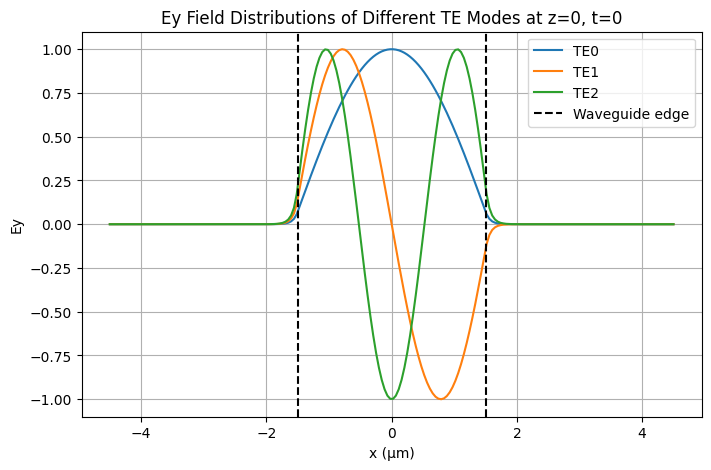

In [9]:
%matplotlib inline
plt.figure(figsize=(8, 5))  
plt.plot(x.cpu().numpy() * 1e6, np.real(Ey0[:,0].cpu().numpy()), label='TE0')
plt.plot(x.cpu().numpy() * 1e6, np.real(Ey1[:,0].cpu().numpy()), label='TE1')
plt.plot(x.cpu().numpy() * 1e6, np.real(Ey2[:,0].cpu().numpy()), label='TE2')
plt.axvline(x=-d/2 * 1e6, color='k', linestyle='--', label='Waveguide edge')
plt.axvline(x=d/2 * 1e6, color='k', linestyle='--')
plt.title("Ey Field Distributions of Different TE Modes at z=0, t=0")
plt.xlabel("x (μm)")
plt.ylabel("Ey")
plt.grid(True)
plt.legend()
plt.show()